In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## Step1: Importing Packages

In [2]:
#imporitng the required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import datetime
import calendar
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Step2: Reading and Exploring Data

### 2.1 Reading the Data from CSV and Exploring metadata

In [3]:
dateparse = lambda x: datetime.datetime.strptime(x, '%d-%m-%Y')

df = pd.read_csv("/content/drive/MyDrive/Lecture Notes/Machine Learning 1/Assignment/Bike_Sharing-Linear_Regression/data/day.csv",
                 parse_dates=['dteday'],
                 date_parser=dateparse)
orignal_copy = df
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2018-01-01,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,2018-01-02,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,2018-01-03,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,2018-01-04,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,2018-01-05,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
#check the shape
df.shape

(730, 16)

In [5]:
#check dataframe for null and datatype 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     730 non-null    int64         
 1   dteday      730 non-null    datetime64[ns]
 2   season      730 non-null    int64         
 3   yr          730 non-null    int64         
 4   mnth        730 non-null    int64         
 5   holiday     730 non-null    int64         
 6   weekday     730 non-null    int64         
 7   workingday  730 non-null    int64         
 8   weathersit  730 non-null    int64         
 9   temp        730 non-null    float64       
 10  atemp       730 non-null    float64       
 11  hum         730 non-null    float64       
 12  windspeed   730 non-null    float64       
 13  casual      730 non-null    int64         
 14  registered  730 non-null    int64         
 15  cnt         730 non-null    int64         
dtypes: datetime64[ns](1), floa

In [6]:
# Description of the data
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


### 2.2 Deriving New Data Columns using the columns which are available

In [7]:
# Converting the date column to get quater
df['quarter'] = df['dteday'].dt.to_period('Q')

# Creating a new column to check if its first day or last day of Month
df['start_of_month'] = df['dteday'].dt.is_month_start.astype(int)
df['end_of_month'] = df['dteday'].dt.is_month_end.astype(int)

# Deriving New column using date i.e "week_of_month"
def week_of_month(tgtdate):
    tgtdate = tgtdate.to_pydatetime()

    days_this_month = calendar.mdays[tgtdate.month]
    for i in range(1, days_this_month):
        d = datetime.datetime(tgtdate.year, tgtdate.month, i)
        if d.day - d.weekday() > 0:
            startdate = d
            break
    return (tgtdate - startdate).days //7 + 1

df['week_of_month'] = df['dteday'].apply(week_of_month)

# Step3: Cleaning Data

### 3.1 Cleaning the data type

In [8]:
# Removing Trailing Spaces in entire dataframe
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

### 3.2 Drop columns that are irrelavent

In [9]:
# Droping instant column since it has nothing to do with target
df.drop(['instant'], axis = 1, inplace = True)

# Dropping casual and registered Columns Since it's sum is directly the target. This could be a major issue for data leak
df.drop(['casual'], axis = 1, inplace = True)
df.drop(['registered'], axis = 1, inplace = True)

# Droping the dteday since date is not relavent here
df.drop(['dteday'], axis = 1, inplace = True)

### 3.2 Check for Missing values

- No missing Values were found as we have seen above. Verifying the claim for other columns:

In [10]:
df.isnull().sum()

season            0
yr                0
mnth              0
holiday           0
weekday           0
workingday        0
weathersit        0
temp              0
atemp             0
hum               0
windspeed         0
cnt               0
quarter           0
start_of_month    0
end_of_month      0
week_of_month     0
dtype: int64

### 3.3 Checking for Outliers in the dataset

In [11]:
#Unique values in all columns
df.nunique()

season              4
yr                  2
mnth               12
holiday             2
weekday             7
workingday          2
weathersit          3
temp              498
atemp             689
hum               594
windspeed         649
cnt               695
quarter             8
start_of_month      2
end_of_month        2
week_of_month       6
dtype: int64

As we can see
Categorical Values are season, yr, mnth, holiday, weekday, workingday, weathersit

Rest are continuous Variables 

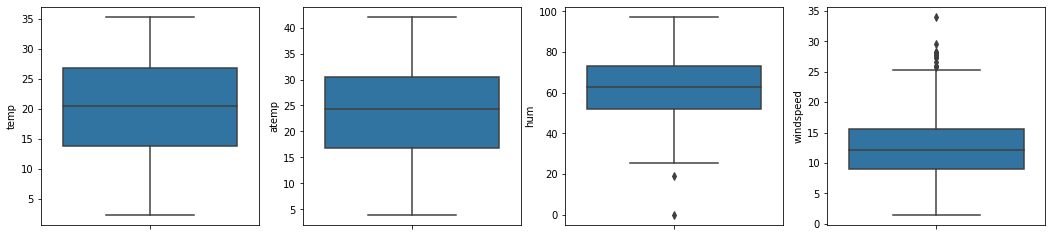

In [12]:
# Draw box plots for indepent variables with continuous values
cols = ['temp', 'atemp', 'hum', 'windspeed']
plt.figure(figsize=(18,4))

i = 1
for col in cols:
    plt.subplot(1,4,i)
    sns.boxplot(y=col, data=df)
    i+=1

As we can see that for all the contineuos variable, there are no outliers

# 4. EDA

#### 4.1 Converting Seasons , day, and months's numerical values to categorical values

In [13]:
df.season.replace({1:"spring", 2:"summer", 3:"fall", 4:"winter"},inplace = True)

df.weathersit.replace({1:'good',2:'moderate',3:'bad',4:'severe'},inplace = True)

df.mnth = df.mnth.replace({1: 'jan',2: 'feb',3: 'mar',4: 'apr',5: 'may',6: 'jun',
                  7: 'jul',8: 'aug',9: 'sept',10: 'oct',11: 'nov',12: 'dec'})

df.weekday = df.weekday.replace({0: 'sun',1: 'mon',2: 'tue',3: 'wed',4: 'thu',5: 'fri',6: 'sat'})
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,quarter,start_of_month,end_of_month,week_of_month
0,spring,0,jan,0,sat,0,moderate,14.110847,18.18125,80.5833,10.749882,985,2018Q1,1,0,1
1,spring,0,jan,0,sun,0,moderate,14.902598,17.68695,69.6087,16.652113,801,2018Q1,0,0,1
2,spring,0,jan,0,mon,1,good,8.050924,9.47025,43.7273,16.636703,1349,2018Q1,0,0,1
3,spring,0,jan,0,tue,1,good,8.200000,10.60610,59.0435,10.739832,1562,2018Q1,0,0,1
4,spring,0,jan,0,wed,1,good,9.305237,11.46350,43.6957,12.522300,1600,2018Q1,0,0,1


### 4.2 Data Analysis

We now step into Analysis of the data which has been cleaned. For Data Analysis, We can Classify it into Broad Terms:

*   Univariate Analysis
*   Bivariate Analysis
*   Multivariate Analysis

For sake of this Assignment, we will be focusing examples from Univariate Analysis and Bivariate Analysis.

These anaylsis can help give Driving Factors for taking key decisions in order to check for demand on different Parameters using our Linear Regression Models.

###4.2.1 Univariate Analysis

Univariate analysis is perhaps the simplest form of statistical analysis. Like other forms of statistics, it can be inferential or descriptive. The key fact is that only one variable is involved. Univariate analysis can yield misleading results in cases in which multivariate analysis is more appropriate.

Building on this, we go ahead and point out various Univariate Analysis results.

In [14]:
# Overall Average Count of the Bike Demand
print("Mean Count of Bike : {}".format(df['cnt'].mean()))

Mean Count of Bike : 4508.006849315068


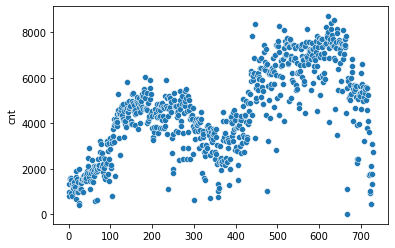

In [15]:
#Scatter Plot of Count
sns.scatterplot(df.index, df['cnt'])

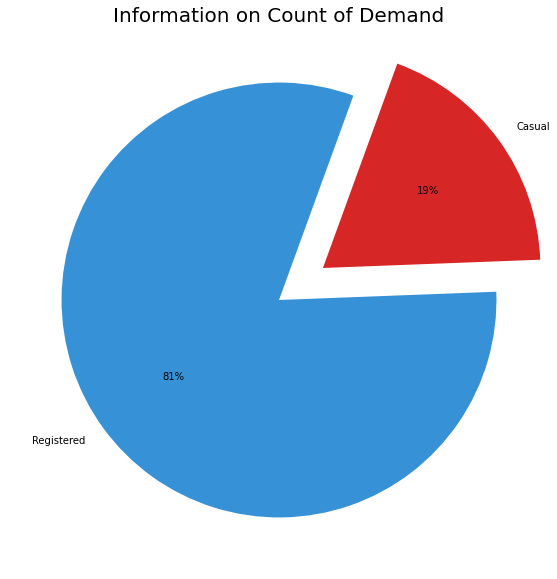

In [46]:
data = [orignal_copy['registered'].sum(), orignal_copy['casual'].sum()]
labels = ['Registered', 'Casual']
plt.figure(figsize = (10,10))
colors = ["#3791D7", "#D72626"]
plt.title('Information on Count of Demand', fontsize=20)
#create pie chart
plt.pie(data,explode=[0,0.25], labels = labels, colors = colors, autopct='%.0f%%', startangle=70)
plt.show()

#### 4.2.2 Bivariate Analysis

Bivariate analysis is one of the simplest forms of quantitative analysis. It involves the analysis of two variables, for the purpose of determining the empirical relationship between them. Bivariate analysis can be helpful in testing simple hypotheses of association.

Building on Univariate Analysis, We can go ahead and start with Relationship between different variables in the dataset.

We performed Correlation for each Non-Categorical Data, i.e. Continuous data column to find any Correlations

<Figure size 1080x2160 with 0 Axes>

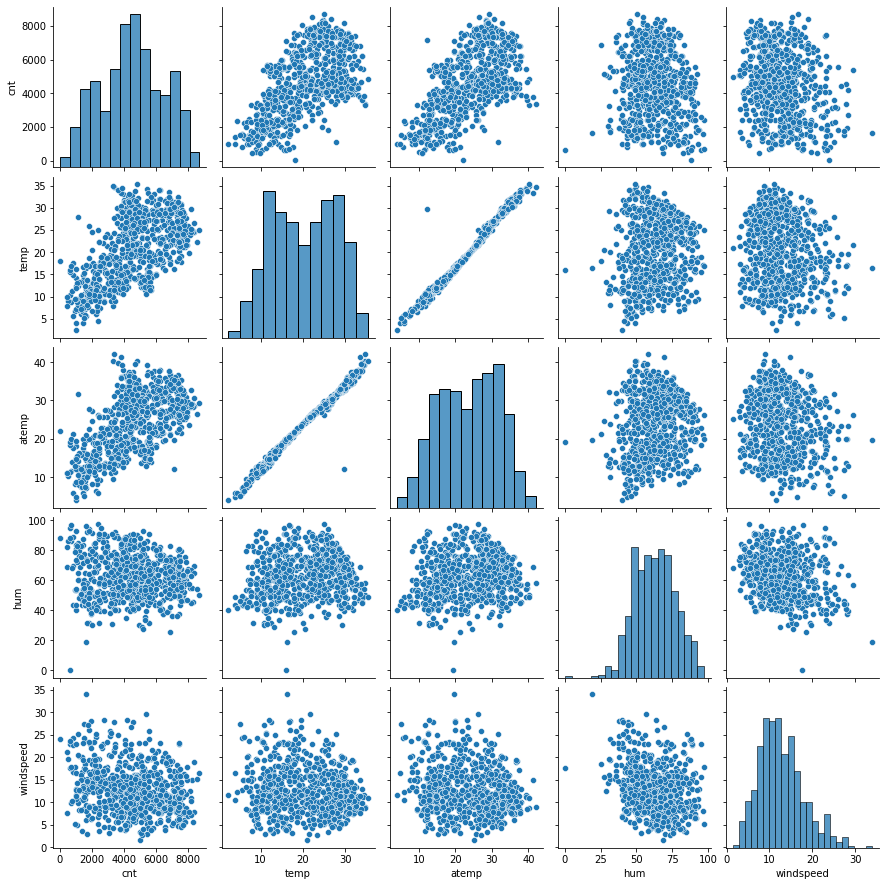

In [17]:
plt.figure(figsize = (15,30))
sns.pairplot(data=df,vars=['cnt', 'temp', 'atemp', 'hum','windspeed'])
plt.show()

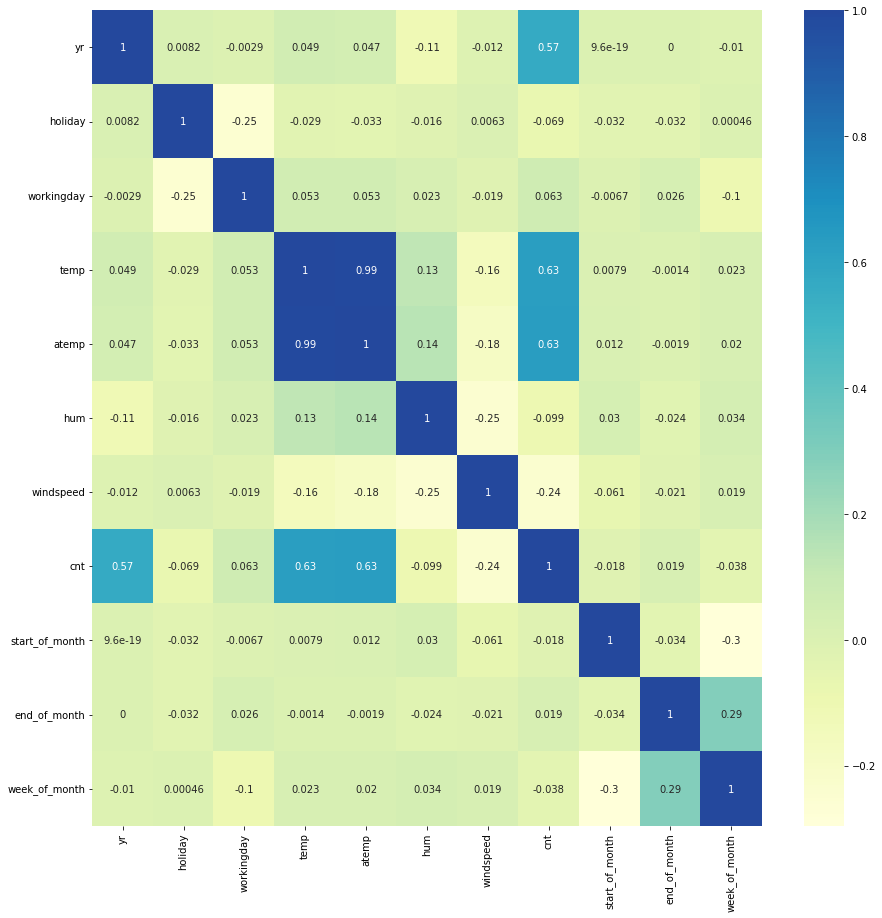

In [44]:
#Correlations for numeric variables
plt.figure(figsize = (15,15))
sns.heatmap(df.corr(), cmap="YlGnBu", annot = True , center=0.5)
plt.show()

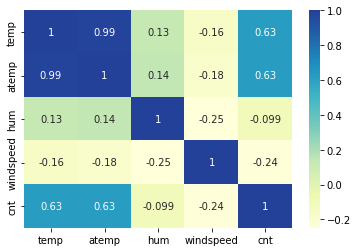

In [43]:
# Heat Map for Contineous Variables
sns.heatmap(df[['temp','atemp','hum','windspeed','cnt']].corr(), cmap='YlGnBu', annot = True, center=0.5)
plt.show()